In [1]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from transformers import AutoImageProcessor, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, get_cosine_schedule_with_warmup
from torchvision.transforms import transforms, Normalize
from torchvision.transforms import Resize, Normalize, Compose, ToPILImage, ToTensor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from tqdm import tqdm
from torchvision import models, transforms
from collections import deque
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import copy as cp
import math
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = 'cuda:0'
batch_size = 24
seed = 42
max_length = 200
random.seed(seed)
torch.random.manual_seed(seed)
import numpy as np
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
loss_fn = nn.CrossEntropyLoss()
transform = transforms.Compose([
    # ToPILImage(),
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
image_encoder = models.resnet34(pretrained=True) #34
num_ftrs = image_encoder.fc.in_features
image_encoder.fc = Identity()
image_encoder = image_encoder.to(device)
text_tokenizer = AutoTokenizer.from_pretrained("Your Tokenizer Path")
text_model = AutoModel.from_pretrained("Your Model Path").to(device)


/home/sjh/anaconda3/envs/lawliet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sjh/anaconda3/envs/lawliet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sjh/anaconda3/envs/lawliet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
train_path = 'Train Set Path'
test_path = 'Test Set Path'
with open(train_path, 'rb') as f:
    train_set_data = pickle.load(f)
with open(test_path, 'rb') as f:
    test_set_data = pickle.load(f)
print('train_set:', len(train_set_data))
print('test_set:', len(test_set_data))


train_set: 6202
test_set: 1759


In [37]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx][0]
        image = transform(self.data[idx][1])
        label = self.data[idx][2]
        return text, image, label
def cleanSST(string):
    string = re.sub(u"[，。 :,.；|-“”——_/nbsp+&;@、《》～（）())#O！：【】]", "", string)
    return string.strip().lower()
def get_real_data(train_set_data):
    # 选择 label 为 0 的元素
    real_train_set_data = [item for item in train_set_data if item[2] == 0]
    return real_train_set_data


class uni_deep_relation(nn.Module):
    def __init__(self, input_dim, i=1):
        super(uni_deep_relation, self).__init__()

        alpha = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        I = torch.eye(input_dim)
        self.alpha = nn.Parameter(alpha+I)

        beta_0 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.beta_0 = nn.Parameter(beta_0)
        beta_1 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.beta_1 = nn.Parameter(beta_1)

    def forward(self, x):
        x = x.div(x.norm(p=torch.inf)) # 如果想要减小批次带来的随机影响，可以使用理论值代替 .div(math.sqrt(2*math.log(x.shape[0]*x.shape[1])))， 之后的其他模块同样可以通过这个理论值代替批次统计值

        out = x@self.alpha + (x@self.beta_0)*(x@self.beta_1)
        return out

    
class multi_deep_relation(nn.Module):
    def __init__(self, input_dim, i=1):
        super(multi_deep_relation, self).__init__()
        alpha = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        I = torch.eye(input_dim)
        self.alpha = nn.Parameter(alpha+I)

        beta_0 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.beta_0 = nn.Parameter(beta_0)
        beta_1 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.beta_1 = nn.Parameter(beta_1)

        gamma_0 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.gamma_0 = nn.Parameter(gamma_0)
        gamma_1 = nn.init.xavier_uniform_(Parameter(torch.empty(input_dim,input_dim)))
        self.gamma_1 = nn.Parameter(gamma_1)

    def forward(self, img_text, i = 1): #示例为 T2I
        img = img_text[0]
        text = img_text[1]
        img = img.div(img.norm(p = torch.inf))
        text = text.div(text.norm(p = torch.inf))

        out = img@self.alpha + (text@self.beta_0)*(img@self.beta_1) + (img@self.gamma_0)*(img@self.gamma_1) 
        return out

class step_fuse(nn.Module):
    def __init__(self, input_dim, i=1):
        super(step_fuse, self).__init__()
        self.input_dim = input_dim
        self.t2i_multi_deep = multi_deep_relation(input_dim, i)
        self.i2t_multi_deep = multi_deep_relation(input_dim, i)
    
    def forward(self, img_text):
        img = img_text[0]
        text = img_text[1]
        t2i = self.t2i_multi_deep((img, text))
        i2t = self.i2t_multi_deep((text, img))
        return (t2i, i2t)

class MDR(nn.Module):
    def __init__(self, img_dim, text_dim, deep_num=8):
        super(MDR, self).__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        multi_deeps = []
        for i in range(deep_num):
            multi_deeps.append(step_fuse(img_dim, i+1))
        self.multi_deep_atts = nn.Sequential(*multi_deeps)
    
    def forward(self, img, text):
        inputs = (img, text)
        i2t_outputs = []
        t2i_outputs = []
        
        for layer in self.multi_deep_atts:
            i2t, t2i = layer(inputs)  
            i2t_outputs.append(i2t.data.unsqueeze(0)) 
            t2i_outputs.append(t2i.data.unsqueeze(0)) 
            inputs = (i2t, t2i)    
        i2t_tensor = torch.cat(i2t_outputs, dim=0)
        t2i_tensor = torch.cat(t2i_outputs, dim=0)
        final_i2t = i2t_outputs[-1][0]
        final_t2i = t2i_outputs[-1][0]
        return final_i2t, final_t2i, i2t_tensor, t2i_tensor
class UDR(nn.Module):
    def __init__(self, input_dim, deep_num=8):
        super(UDR, self).__init__()
        self.input_dim = input_dim
        uni_deeps = []
        for i in range(deep_num):
            uni_deeps.append(uni_deep_relation(input_dim, i+1))
        self.uni_deeps = nn.Sequential(*uni_deeps)
    def forward(self, input):
        out = self.uni_deeps(input)
        return out

class deep_attention(nn.Module):
    def __init__(self, input_dim, deep_num = 2):
        super(deep_attention, self).__init__()
        self.atts = nn.ModuleList([
                    nn.MultiheadAttention(embed_dim=input_dim, num_heads=8, dropout=0.1)
                    for _ in range(deep_num)
                ])
        self.norm = nn.LayerNorm(input_dim)
    def forward(self, x):
        if(len(x.shape)<=2):
            x = x.unsqueeze(0)
        for layer in self.atts:
            x_1, _ = layer(x, x, x)
            x = x + x_1
            self.norm(x.squeeze(0)).unsqueeze(0)
        x = x.squeeze(0)
        return x

class confidence_linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(confidence_linear, self).__init__()
        self.linear = nn.Sequential(
                nn.Linear(input_dim, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.GELU(),
                nn.Linear(input_dim, output_dim),
            )
    def forward(self, x):
        return self.linear(x)

class Multi_transfomer(nn.Module):
    def __init__(self, t_input_dim, i_input_dim, shared_dim, n_looker = 1, num_class = 2, deep_num=8):
        super(Multi_transfomer, self).__init__()
        self.looker = n_looker
        self.num_class = num_class
        self.t_input_dim = t_input_dim
        self.i_input_dim = i_input_dim
        self.shared_dim = shared_dim
        self.final_dim = shared_dim
        # self.output_dim = output_dim

        self.image_encoder = nn.Linear(i_input_dim, shared_dim)
        self.text_encoder = nn.Linear(t_input_dim, shared_dim)
        self.corre_mdr = MDR(shared_dim, shared_dim, deep_num = deep_num)
        self.classifier = nn.Linear(self.final_dim, num_class)

    def forward(self, t_pooler, i_pooler, return_useful=False):

        i_feature = self.image_encoder(i_pooler)
        t_feature = self.text_encoder(t_pooler)

        i2t, t2i, all_i2t, all_t2i = self.corre_mdr(i_feature, t_feature)

        it_feature = i2t+t2i

        it_pred = self.classifier(it_feature)

        x = it_pred

        all_i2t = all_i2t.mean(dim = 1)
        all_t2i = all_t2i.mean(dim = 1)

        return x, i_feature, t_feature, i2t, t2i, it_feature, (all_i2t.data, all_t2i.data) 

def test(test_loader, plot_tsne = True, plot_useful=True):
    # set eval_mode = True
    for layer in multi_trans_model.modules():
        if hasattr(layer, 'eval_mode'):
            layer.eval_mode = True
    pbar = tqdm(test_loader, desc='Testing')
    text_model.eval()
    image_encoder.eval()
    multi_trans_model.eval()
    # clip_model.eval()
    total_acc = 0
    total_samples = 0
    total_loss = 0
    i_confidence = 0
    t_confidence = 0
    it_confidence = 0
    it_features = []
    i_features = []
    t_features = []
    i2t_features = []
    t2i_features = []
    final_features = []
    labels = []
    preds = []
    i_norms = []
    t_norms = []
    it_norms = []
    i2t_norms = []
    t2i_norms = []
    useful_scores = torch.zeros(4, n_looker)
    all_data = []
    with torch.no_grad():
        for text, image, label in pbar:
            total_samples += len(label)
            image = image.to(device)
            label = label.to(device)
            inputs = text_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
            t_outs = text_model(**inputs)
            i_outs = image_encoder(image)
            final_out, i_feature, t_feature, i2t, t2i, final_feature, all_datas = multi_trans_model(t_outs.pooler_output, i_outs, return_useful=True)
            acc = (final_out.argmax(1) == label).sum().item()
            total_loss += loss_fn(final_out, label).item()
            total_acc += acc
            preds.append(final_out.argmax(1).cpu().numpy())
            labels.append(label.cpu().numpy())
            i_norms.append(i_feature.norm(p=2, dim=1).mean().item())
            t_norms.append(t_feature.norm(p=2, dim=1).mean().item())
            i2t_norms.append(i2t.norm(p=2, dim=1).mean().item())
            t2i_norms.append(t2i.norm(p=2, dim=1).mean().item())
            all_data.append(all_datas)
            if(plot_tsne):
                i2t_features.append(i2t.data.cpu().numpy())
                t2i_features.append(t2i.data.cpu().numpy())
                i_features.append(i_feature.data.cpu().numpy())
                t_features.append(t_feature.data.cpu().numpy())
                final_features.append(final_feature.data.cpu().numpy())
            pbar.set_postfix({'acc': total_acc/total_samples, 'loss': total_loss/total_samples})
    report = classification_report(np.concatenate(labels), np.concatenate(preds), target_names=['Fake News', 'Real News'], digits=3)
    print(report)
    print(f"Image Norm: {np.mean(i_norms):.4f}, Text Norm: {np.mean(t_norms):.4f}, I2T Norm: {np.mean(i2t_norms):.4f}, T2I Norm: {np.mean(t2i_norms):.4f}")
    if(plot_tsne):
        image_features = np.concatenate(i_features)
        text_features = np.concatenate(t_features)
        # multimodal_features = np.concatenate(it_features)
        i2t_features = np.concatenate(i2t_features)
        t2i_features = np.concatenate(t2i_features)
        final_features = np.concatenate(final_features)
        labels = np.concatenate(labels)
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
        #设置字体大小
        plt.rcParams.update({'font.size': 13})
        # plt.figure(figsize=(18, 8))
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        for i, c in zip(range(2), colors):
            plt.scatter(image_features[labels == i, 0], image_features[labels == i, 1], c=c, label=i, alpha=0.5, s=1)
        plt.title('Image Features')
        plt.legend()

        plt.subplot(234)
        for i, c in zip(range(2), colors):
            plt.scatter(text_features[labels == i, 0], text_features[labels == i, 1], c=c, label=i, alpha=0.5, s=1)
        plt.title('Text Features')
        plt.legend()

        plt.subplot(233)
        for i, c in zip(range(2), colors):
            plt.scatter(final_features[labels == i, 0], final_features[labels == i, 1], c=c, label=i, alpha=0.5, s=1)
        plt.title('Final Features')
        plt.legend()

        plt.subplot(232)
        for i, c in zip(range(2), colors):
            plt.scatter(i2t_features[labels == i, 0], i2t_features[labels == i, 1], c=c, label=i, alpha=0.5, s=1)
        plt.title('I2T Features')

        plt.subplot(235)
        for i, c in zip(range(2), colors):
            plt.scatter(t2i_features[labels == i, 0], t2i_features[labels == i, 1], c=c, label=i, alpha=0.5, s=1)
        plt.title('T2I Features')
        plt.legend()

        plt.show()
            
    return total_acc/total_samples, total_loss/total_samples, report, all_data
n_looker = 32
multi_trans_model = Multi_transfomer(768, num_ftrs, 768, deep_num=8).to(device)

In [38]:

train_set = CustomDataset(train_set_data)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
test_set = CustomDataset(test_set_data)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)
mask_value = torch.tensor([0.485, 0.456, 0.406], device=device)
optimizer = torch.optim.AdamW(list(image_encoder.parameters()) + list(text_model.parameters()) + list(multi_trans_model.parameters()), lr=2e-5)
text_model = torch.load('best_tailor_text_encoder.pt').to(device)
image_encoder = torch.load('best_tailor_img_encoder.pt').to(device)
multi_trans_model = torch.load('best_tailor_multi_tailor_model.pt').to(device)

Testing: 100%|██████████| 74/74 [00:10<00:00,  6.82it/s, acc=0.919, loss=0.0209]


              precision    recall  f1-score   support

   Fake News      0.937     0.906     0.921       924
   Real News      0.900     0.933     0.916       835

    accuracy                          0.919      1759
   macro avg      0.918     0.919     0.919      1759
weighted avg      0.919     0.919     0.919      1759

Image Norm: 19.6800, Text Norm: 14.3712, I2T Norm: 10.3700, T2I Norm: 12.4657


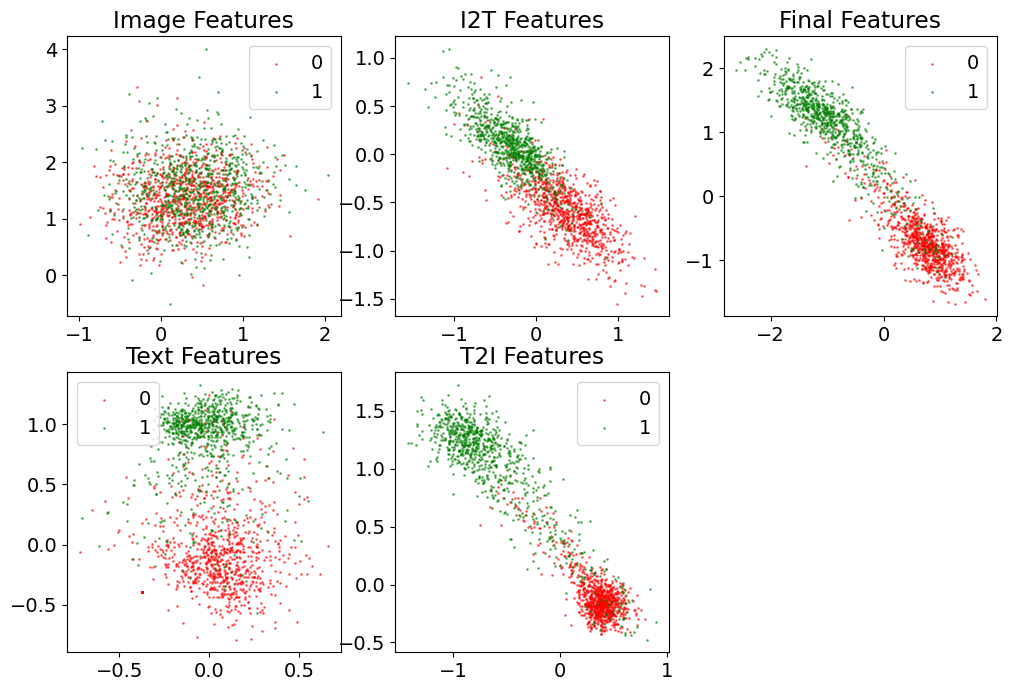

In [39]:
acc, loss, report, all_data = test(test_loader)

In [6]:
i2t_datas = [item[0] for item in all_data]
t2i_datas = [item[1] for item in all_data]

In [7]:
i2t_datas = torch.stack(i2t_datas)
t2i_datas = torch.stack(t2i_datas)

In [8]:
i2t_datas_mean = i2t_datas.mean(dim=0)
t2i_datas_mean = t2i_datas.mean(dim=0)

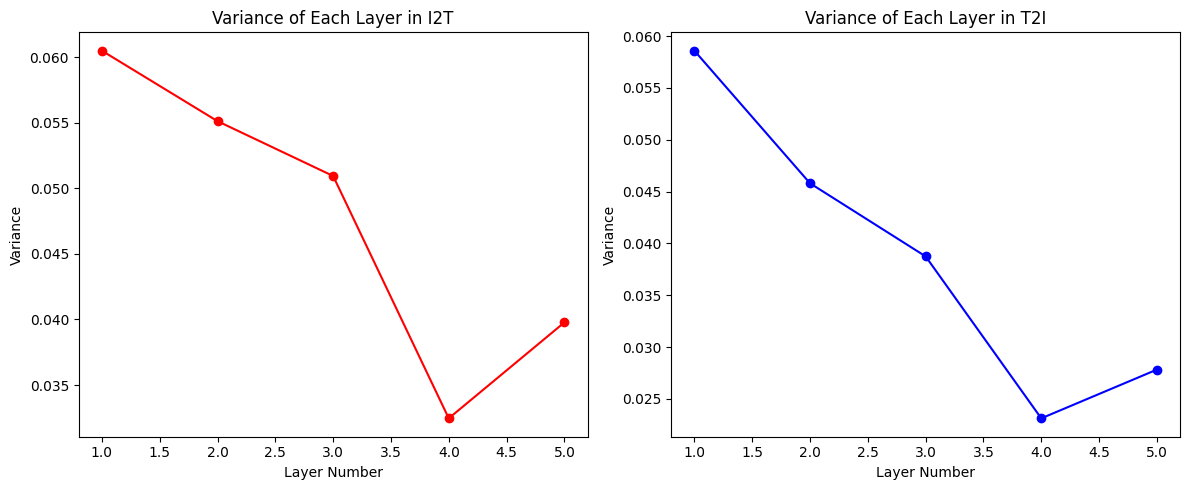

In [9]:

# 初始化列表用于存储方差和均值
variances = []
means = []

# 计算每一层的方差和均值
for i in range(i2t_datas_mean.size(0)):
    layer_var = torch.var(i2t_datas_mean[i])  # 计算每层的方差
    layer_mean = torch.var(t2i_datas_mean[i])  # 计算每层的方差
    variances.append(layer_var.item())  # 转换为Python float并存储
    means.append(layer_mean.item())  # 转换为Python float并存储

# 可视化方差和均值
plt.figure(figsize=(12, 5))

# 绘制方差
plt.subplot(1, 2, 1)
plt.plot(range(1, len(variances) + 1), variances, marker='o', color='r')
plt.xlabel("Layer Number")
plt.ylabel("Variance")
plt.title("Variance of Each Layer in I2T")

# 绘制均值
plt.subplot(1, 2, 2)
plt.plot(range(1, len(means) + 1), means, marker='o', color='b')
plt.xlabel("Layer Number")
plt.ylabel("Variance")
plt.title("Variance of Each Layer in T2I")

plt.tight_layout()
plt.show()

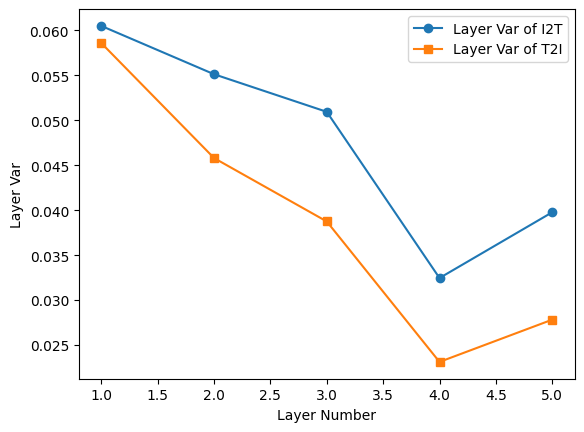

In [10]:
# import matplotlib.pyplot as plt
# layer_changes = []
# for i in range(0, i2t_datas_mean.size(0)):
#     change = i2t_datas_mean[i].var()  # L2范数
#     layer_changes.append(change.item())

# # 可视化
# plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
# plt.xlabel("Layer Number")
# plt.ylabel("Layer Var")
# plt.title("Var of Layers") 
# plt.show()

# 画第一条曲线
x = range(1, len(i2t_datas_mean) + 1)
y1 = [i2t_datas_mean[i].var().item() for i in range(len(i2t_datas_mean))]
y2 = [t2i_datas_mean[i].var().item() for i in range(len(i2t_datas_mean))]
plt.plot(x, y1, label='Layer Var of I2T', marker='o')

# 画第二条曲线
plt.plot(x, y2, label='Layer Var of T2I', marker='s')

# plt.plot(x, y3, label='L2 Norm of Layer 3', marker='s')

# 添加标签和标题
plt.xlabel("Layer Number")
plt.ylabel("Layer Var")
# plt.title("Var of Layers")

# 显示图例
plt.legend()

# 显示图形
plt.show()

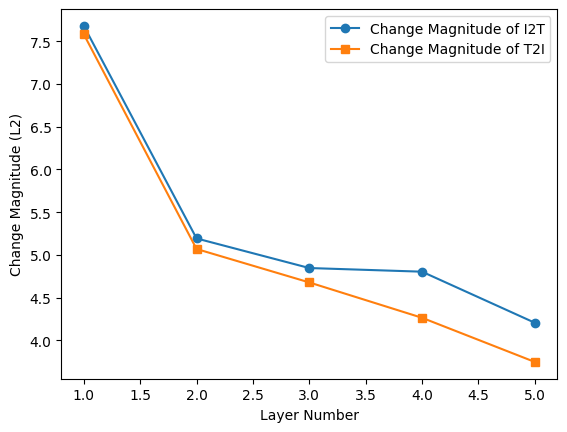

In [11]:
# import matplotlib.pyplot as plt
# layer_changes = []
# for i in range(1, i2t_datas_mean.size(0)):
#     change = (i2t_datas_mean[i] - i2t_datas_mean[i - 1]).var()  # L2范数
#     layer_changes.append(change.item())

# # 可视化
# plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
# plt.xlabel("Layer Number")
# plt.ylabel("Change Magnitude (Var)")
# plt.title("Change Magnitude Between Layers")
# plt.show()



x = range(1, len(i2t_datas_mean) + 1)
y1 = [(i2t_datas_mean[i] - i2t_datas_mean[i - 1]).norm(p=2).item() for i in range(len(i2t_datas_mean))]
y2 = [(t2i_datas_mean[i] - t2i_datas_mean[i - 1]).norm(p=2).item() for i in range(len(i2t_datas_mean))]
plt.plot(x, y1, label='Change Magnitude of I2T', marker='o')

# 画第二条曲线
plt.plot(x, y2, label='Change Magnitude of T2I', marker='s')

# plt.plot(x, y3, label='L2 Norm of Layer 3', marker='s')
plt.xlabel("Layer Number")
plt.ylabel("Change Magnitude (L2)")
# plt.title("Change Magnitude Between Layers")

# 显示图例
plt.legend()

# 显示图形
plt.show()

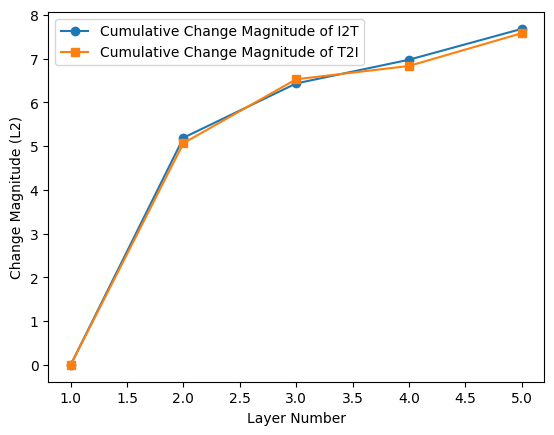

In [13]:
# import matplotlib.pyplot as plt
# layer_changes = []
# for i in range(1, i2t_datas_mean.size(0)):
#     change = ((i2t_datas_mean[i] - i2t_datas_mean[0])).var()  # L2范数
#     layer_changes.append(change.item())

# # 可视化
# plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
# plt.xlabel("Layer Number")
# plt.ylabel("Change Magnitude (Var)")
# plt.title("Cumulative Change Magnitude")
# plt.show()



x = range(1, len(i2t_datas_mean) + 1)
y1 = [(i2t_datas_mean[i] - i2t_datas_mean[0]).norm(p=2).item() for i in range(len(i2t_datas_mean))]
y2 = [(t2i_datas_mean[i] - t2i_datas_mean[0]).norm(p=2).item() for i in range(len(i2t_datas_mean))]
plt.plot(x, y1, label='Cumulative Change Magnitude of I2T', marker='o')

# 画第二条曲线
plt.plot(x, y2, label='Cumulative Change Magnitude of T2I', marker='s')

# plt.plot(x, y3, label='L2 Norm of Layer 3', marker='s')
plt.xlabel("Layer Number")
plt.ylabel("Change Magnitude (L2)")
# plt.title("Cumulative Change Magnitude")

# 显示图例
plt.legend()

# 显示图形
plt.show()

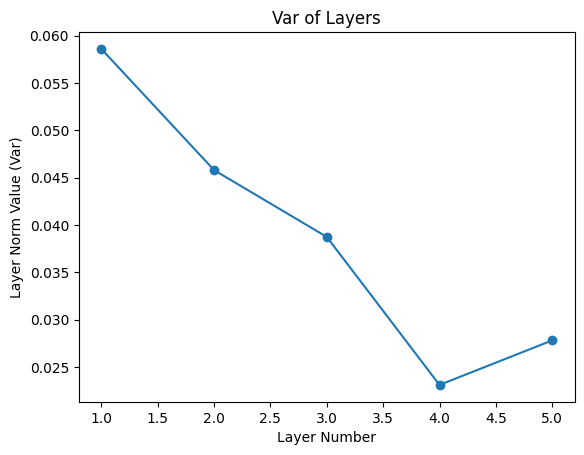

In [14]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = t2i_datas_mean[i].var()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Layer Norm Value (Var)")
plt.title("Var of Layers")
plt.show()

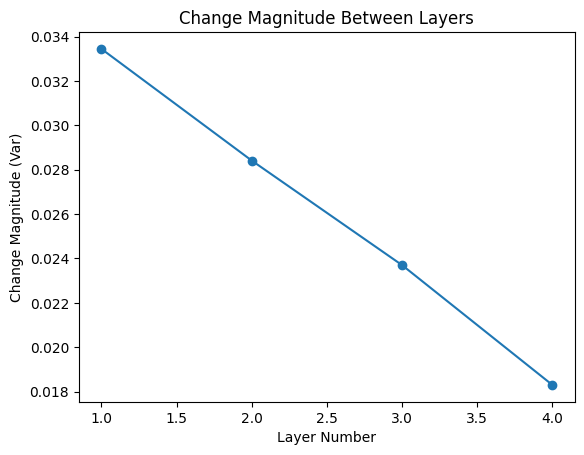

In [15]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(1, t2i_datas_mean.size(0)):
    change = (t2i_datas_mean[i] - t2i_datas_mean[i - 1]).var()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Change Magnitude (Var)")
plt.title("Change Magnitude Between Layers")
plt.show()

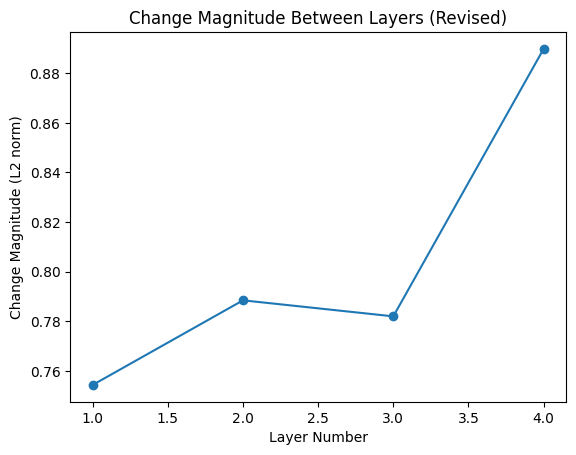

In [16]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(1, t2i_datas_mean.size(0)):
    change = torch.norm(t2i_datas_mean[i] - t2i_datas_mean[i - 1], p=2).div(t2i_datas_mean[i - 1].norm(p=2))  # L2范数.
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Change Magnitude (L2 norm)")
plt.title("Change Magnitude Between Layers (Revised)")
plt.show()

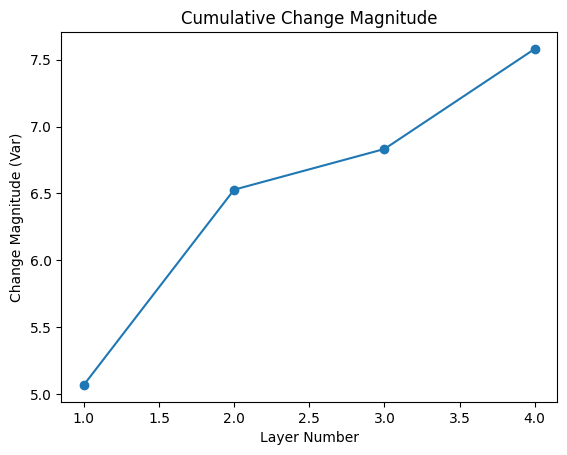

In [17]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(1, i2t_datas_mean.size(0)):
    change = torch.norm((t2i_datas_mean[i] - t2i_datas_mean[0]), p=2)  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Change Magnitude (Var)")
plt.title("Cumulative Change Magnitude")
plt.show()

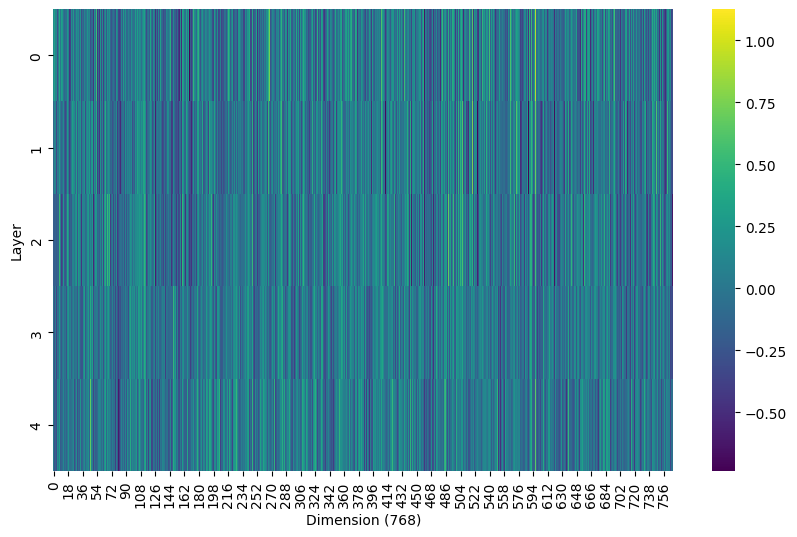

In [18]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap((i2t_datas_mean).cpu().numpy(), cmap="viridis", cbar=True)
plt.xlabel("Dimension (768)")
plt.ylabel("Layer")
# plt.title("Heatmap of Layer Outputs")
plt.show()

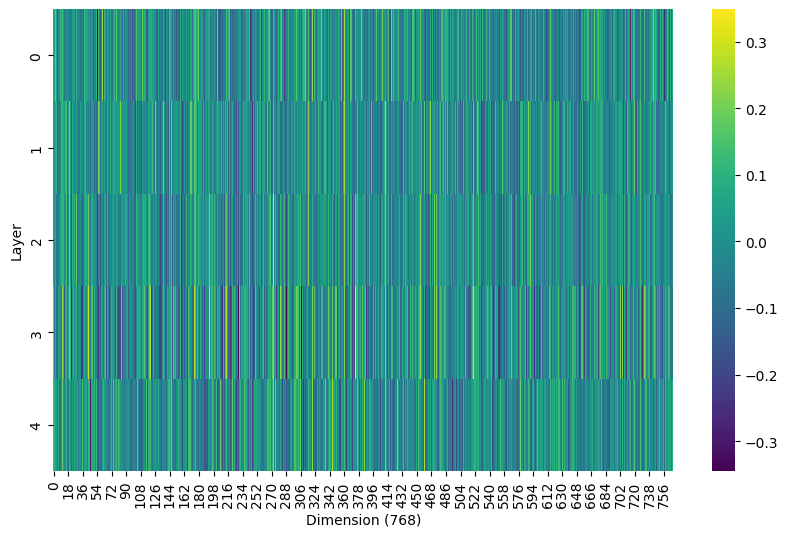

In [19]:
import seaborn as sns 
plt.figure(figsize=(10, 6))
sns.heatmap((i2t_datas[0]-i2t_datas[1]).cpu().numpy(), cmap="viridis", cbar=True)
plt.xlabel("Dimension (768)")
plt.ylabel("Layer")
# plt.title("Heatmap of Layer Outputs")
plt.show()

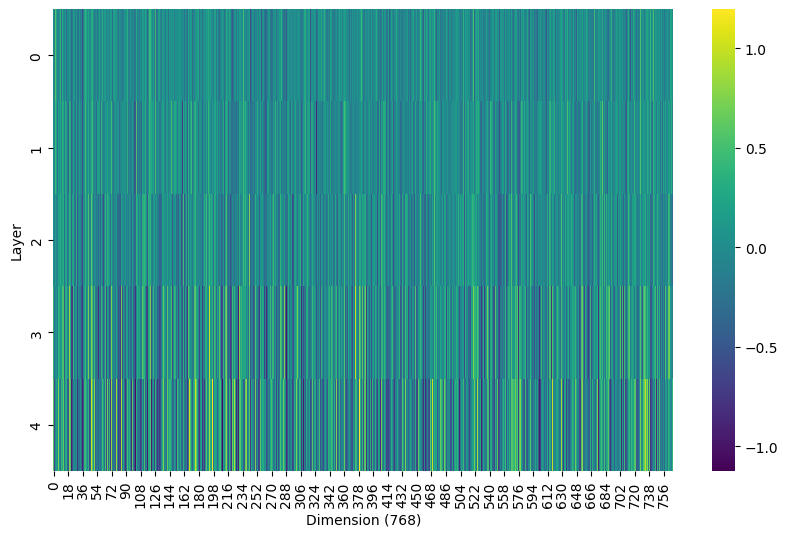

In [20]:
import seaborn as sns 
plt.figure(figsize=(10, 6))
sns.heatmap(((i2t_datas[0]-i2t_datas[-1])).cpu().numpy(), cmap="viridis", cbar=True)
plt.xlabel("Dimension (768)")
plt.ylabel("Layer")
# plt.title("Heatmap of Layer Outputs")
plt.show()

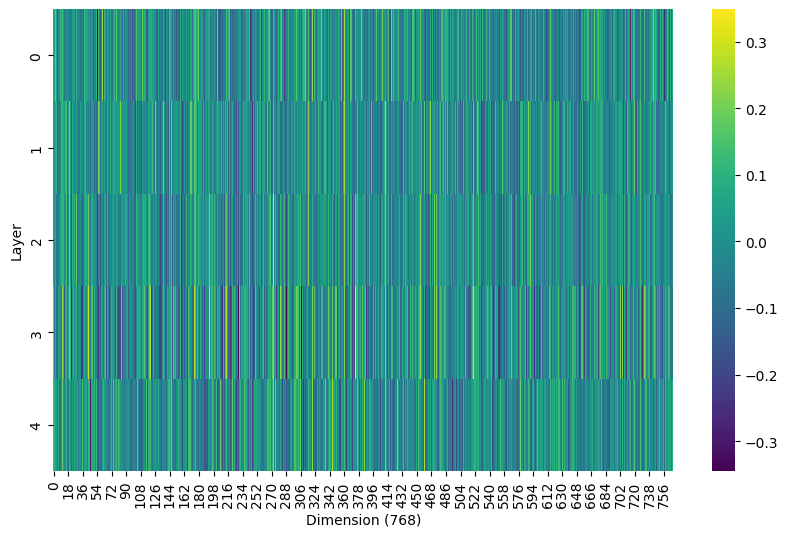

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(((i2t_datas[0]-i2t_datas[1])).cpu().numpy(), cmap="viridis", cbar=True)
plt.xlabel("Dimension (768)")
plt.ylabel("Layer")
# plt.title("Heatmap of Layer Outputs")
plt.show()

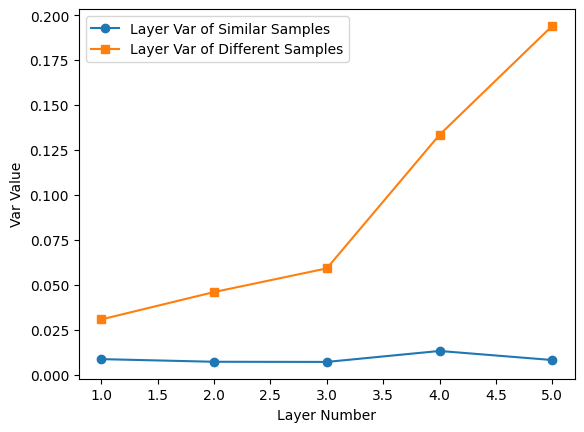

In [22]:
# 画第一条曲线
x = range(1, len(i2t_datas_mean) + 1)
y1 = [(i2t_datas[0]-i2t_datas[1]).var(dim=-1,keepdim=True)[i].item() for i in range(len(i2t_datas_mean))]
y2 = [(i2t_datas[0]-i2t_datas[-1]).var(dim=-1,keepdim=True)[i].item() for i in range(len(i2t_datas_mean))]
plt.plot(x, y1, label='Layer Var of Similar Samples', marker='o')

# 画第二条曲线
plt.plot(x, y2, label='Layer Var of Different Samples', marker='s')

# plt.plot(x, y3, label='L2 Norm of Layer 3', marker='s')

# 添加标签和标题
plt.xlabel('Layer Number')
plt.ylabel('Var Value')
# plt.title('Var of Layers')

# 显示图例
plt.legend()

# 显示图形
plt.show()

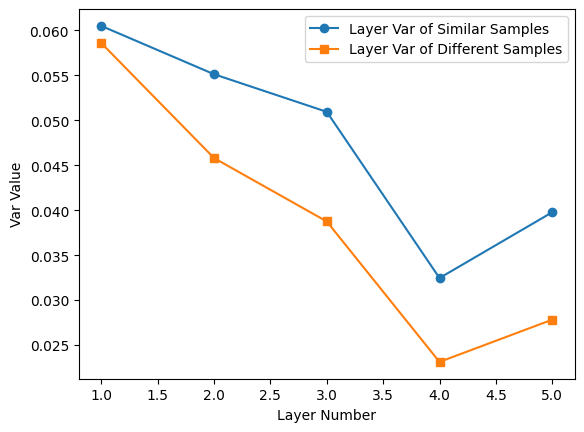

In [23]:
# 画第一条曲线
x = range(1, len(i2t_datas_mean) + 1)
y1 = [(i2t_datas_mean).var(dim=-1,keepdim=True)[i].item() for i in range(len(i2t_datas_mean))]
y2 = [(t2i_datas_mean).var(dim=-1,keepdim=True)[i].item() for i in range(len(i2t_datas_mean))]
plt.plot(x, y1, label='Layer Var of Similar Samples', marker='o')

# 画第二条曲线
plt.plot(x, y2, label='Layer Var of Different Samples', marker='s')

# plt.plot(x, y3, label='L2 Norm of Layer 3', marker='s')

# 添加标签和标题
plt.xlabel('Layer Number')
plt.ylabel('Var Value')
# plt.title('Var of Layers')

# 显示图例
plt.legend()

# 显示图形
plt.show()

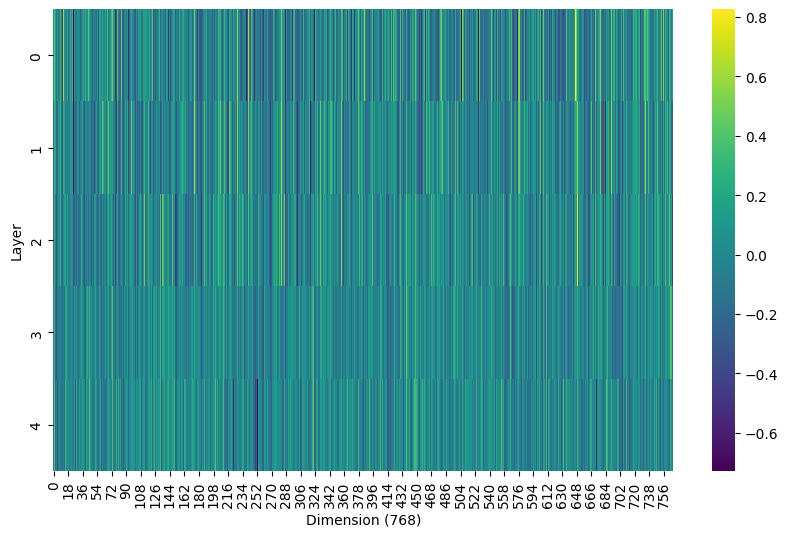

In [24]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(t2i_datas_mean.cpu().numpy(), cmap="viridis", cbar=True)
plt.xlabel("Dimension (768)")
plt.ylabel("Layer")
# plt.title("Heatmap of Layer Outputs")
plt.show()


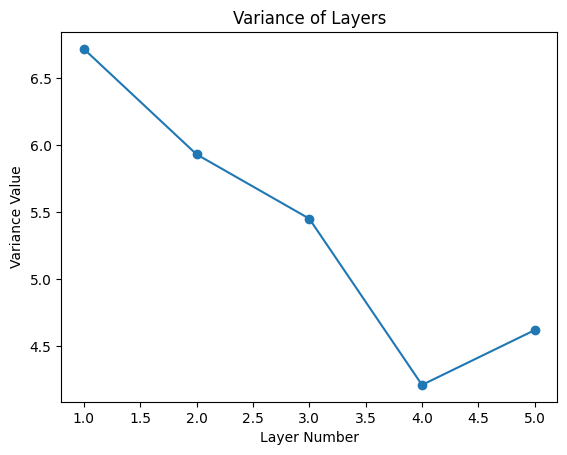

In [25]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = torch.norm(t2i_datas_mean[i], p=2)  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Variance Value")
plt.title("Variance of Layers")
plt.show()

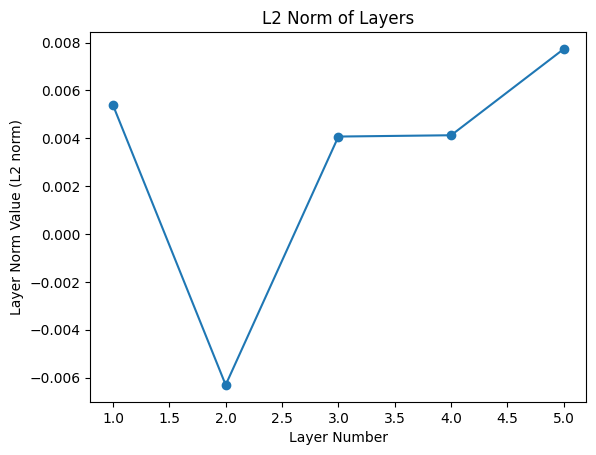

In [26]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = i2t_datas_mean[i].mean()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Layer Norm Value (L2 norm)")
plt.title("L2 Norm of Layers")
plt.show()

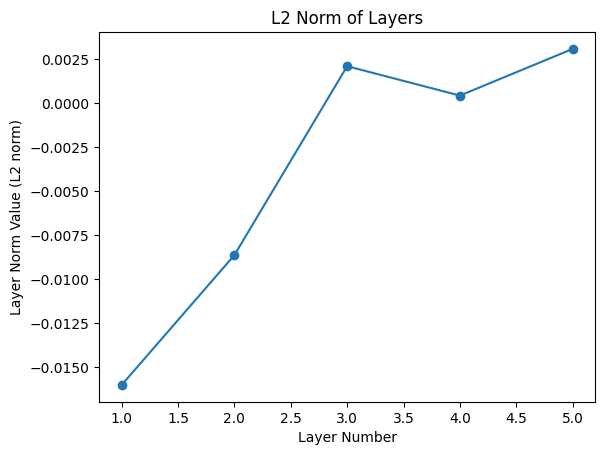

In [27]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = t2i_datas_mean[i].mean()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Layer Norm Value (L2 norm)")
plt.title("L2 Norm of Layers")
plt.show()

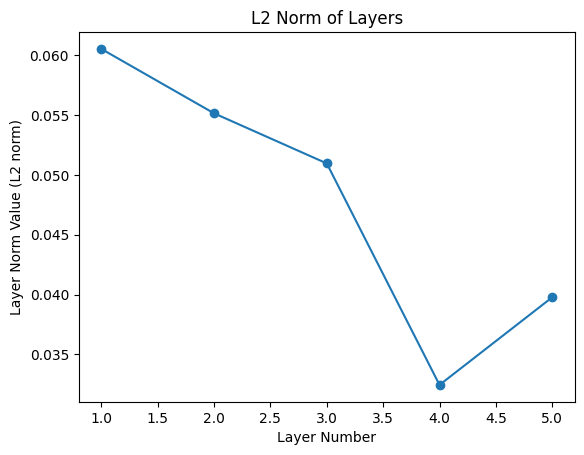

In [28]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = i2t_datas_mean[i].var()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Layer Norm Value (L2 norm)")
plt.title("L2 Norm of Layers")
plt.show()

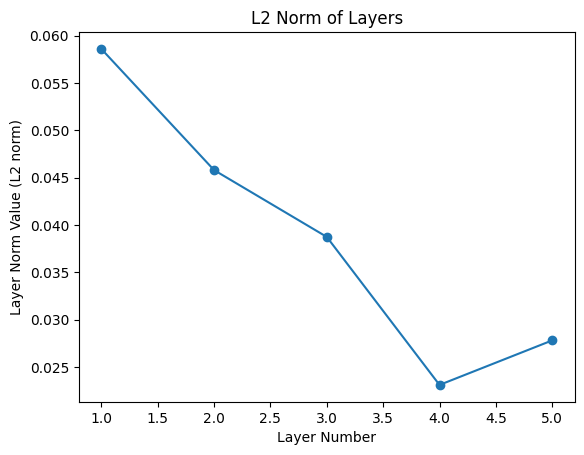

In [29]:
import matplotlib.pyplot as plt
layer_changes = []
for i in range(0, t2i_datas_mean.size(0)):
    change = t2i_datas_mean[i].var()  # L2范数
    layer_changes.append(change.item())

# 可视化
plt.plot(range(1, len(layer_changes) + 1), layer_changes, marker='o')
plt.xlabel("Layer Number")
plt.ylabel("Layer Norm Value (L2 norm)")
plt.title("L2 Norm of Layers")
plt.show()